# Geochimie 2018-2019 M1 ACSC : séance 2
Le problème repris est celui du problème franco-allemand vu en TD (P0), sur les pluies acides. On a formulé le problème de l'évolution de la masse d'un polluant (par exemple le soufre = dioxyde de soufre + sulfate) par un modèle de boîte où l'on décrit la conservation de la masse (voir cours Daniel Jacob, équations 3.7, 3.8) :
$$ \frac{dm}{dt} = S - k m $$
Pour la résolution numérique, on a exprimé la dérivée temporelle via les valeurs de $m$ à deux temps consécutifs $t_n$ et $t_{n+1}$, $dm/dt = (m_{n+1}-m_n)/dt$, ce qui permet de calculer la masse à $t_{n+1}$ à partir de celle à $t_{n}$ :
$$ m_{n+1} = m_{n} + (S - k m_{n} ) \times dt $$
On obtient donc l'évolution temporelle de la masse de polluant, que l'on peut tracer.

In [1]:
import numpy as np                        # pour le calcul numérique
import matplotlib.pyplot as plt           # pour les plots, et dessous, pour que les plots apparaissent dans le notebook
%matplotlib inline

## Initialisation de paramètres et de la masse au temps 0

Il faut donner des valeurs aux paramètres qui ne sont pas explicitement obtenus par notre modèle au cours du temps. Et il faut donner une valeur initiale à la masse pour démarrer le calcul de l'évolution temporelle.

On donne des noms un peu explicite aux variables pour bien les reconnaitre.

Aussi, on donne $t_0$ correspondant au 1er juillet à minuit, et on cherche la masse de NO le 19 juillet à 16h.

Enfin, on considère une source d'émission sinusoïdale, avec un maxima de $800/365$ GT à 14h et un minima de 0 à 2h du matin.

In [2]:
V = 10*3600                                 # en m/h
d = 1000e3                                  # en m
max_source = 800/365.                       # en GT
kphc = 1./4. /24                            # constante physico-chimique, en /h
kout = V/d   /24                            # constante de perte par transport (V/d) en /h
ktot = kphc + kout

mNO = 0.                                    # Masse initiale de NO (en T)

### Données relative au temps
dt = 1                                      # en heure
# nombre d'heure entre le 1er juillet 00:00 et le 19 juillet 16:00
Nstep = 24 * 19 + 16                        # Nombre de pas de temps que l'on prévoit de calculer. Variable entière.

time_steps = np.arange(Nstep)

### Terme source avec une variabilité journalière
T = 24               # période
omega = 2*np.pi/T    # pulsation
tau = 4              # déphasage temporel
phi = tau*2*np.pi/T  # décalage de phase

ENO = max_source * (1 - np.sin(omega*time_steps + phi))

La source sinusoïde a une période de 24h, donc on divise $2 \pi$ par $24$. Elle ne démarre pas à 0 mais à 2 heure, donc on enlève 2.

Source mean: 2.1877593433769005
Source max: 4.383561643835616   Source min: 0.0


Text(0,0.5,'Emission NO (GT/h)')

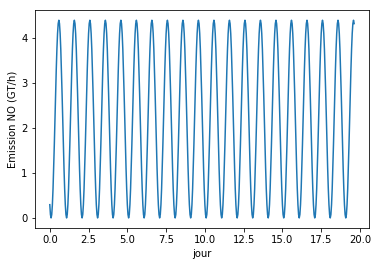

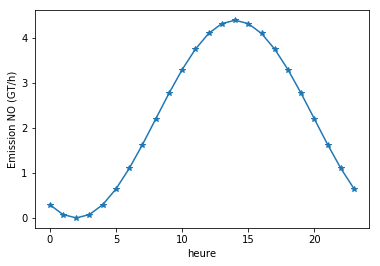

In [3]:
### Graph
plt.plot(time_steps/24, ENO)
plt.xlabel("jour")
plt.ylabel("Emission NO (GT/h)")

print("Source mean: "+str(ENO.mean()))
print("Source max: {max}   Source min: {min}".format(max=ENO.max(), min=ENO.min()))

### Zoom sur 1 jours
plt.figure() # on ouvre une nouvelle figure
plt.plot(time_steps[:24], ENO[:24], '-*')
plt.xlabel("heure")
plt.ylabel("Emission NO (GT/h)")

## Boucle temporelle

On va calculer les valeurs de $m$ au cours du temps. Mais auparavant, il faut prévoir les objets nécessaires à la sauvegarde des données calculées (ici, seulement un vecteur pour stocker la série temporelle de $m$).

In [4]:
mNO = 0
mNO_series_euler = np.zeros(Nstep)               # Vecteur de Nstep valeurs, rempli de 0
for i in range(Nstep-1):
    mNO = mNO + (ENO[i] - ktot*mNO) * dt
    mNO_series_euler[i+1] = mNO

## Plot de la série temporelle

Text(0,0.5,'Masse de NO (GT)')

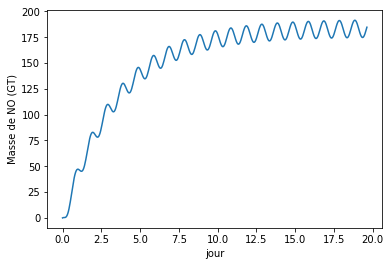

In [5]:
plt.plot(time_steps/24, mNO_series_euler)
plt.xlabel("jour")
plt.ylabel("Masse de NO (GT)")

In [6]:
solution = "Ainsi, le 19 juillet à 16h, il y a {val:.2f} GT de NO."
print(solution.format(val=mNO_series_euler[-1]))

Ainsi, le 19 juillet à 16h, il y a 184.74 GT de NO.


# Une amélioration: le leap-frog

Le schéma précédent s'obtenait en développant la série de Taylor :

$$
f(a+h) = f(a) + h\frac{df}{dt} + \frac{h^2}{2}\frac{d^2f}{dt^2} + \frac{h^3}{6}\frac{d^3f}{dt^3} + ... 
$$

en tronquant à l'ordre 2. On obtient donc une erreur de l'ordre de $o(h^2)$.

De manière similaire, on obtient une approximation de $f(a-h)$ :

$$
f(a-h) = f(a) - h\frac{df}{dt} + \frac{h^2}{2}\frac{d^2f}{dt^2} - \frac{h^3}{6}\frac{d^3f}{dt^3} + ... 
$$

Si l'on soustrait ces deux equations, on obtient alors :

$$
f(a+h) - f(a-h) = 0 + 2 h \frac{df}{dt} + 0 + \frac{h^3}{3}\frac{d^3f}{dt^3} + ...
$$

Soit, en réarangant l'équation :

$$
f(a+h)= f(a-h) + 2 h \frac{df}{dt} + \frac{h^3}{3}\frac{d^3f}{dt^3} + ...
$$

Ainsi, l'approximation $f(a+h) = f(a-h) + 2 h \frac{df}{dt}$ n'a plus qu'une erreur de tronquature de l'ordre de $o(dt^3)$ !

Ce schéma s'appelle le *leap-frog* car on calcul $X^{n+1}$ en fonction de $X^{n-1}$ mais de la dérivée de $X$ à $n$.

In [7]:
V = 10*3600                                 # en m/h
d = 1000e3                                  # en m
max_source = 800/365.                       # en GT
kphc = 1./4. /24                            # constante physico-chimique, en /h
kout = V/d   /24                            # constante de perte par transport (V/d) en /h
ktot = kphc + kout

mNO = 0.                                    # Masse initiale de NO (en T)

### Données relative au temps
dt = 1                                      # en heure
# nombre d'heure entre le 1er juillet 00:00 et le 19 juillet 16:00
Nstep = 24 * 19 + 16                        # Nombre de pas de temps que l'on prévoit de calculer. Variable entière.

time_steps = np.arange(Nstep)

### Terme source avec une variabilité journalière
T = 24               # période
omega = 2*np.pi/T    # pulsation
tau = 4              # déphasage temporel
phi = tau*2*np.pi/T  # décalage de phase

ENO = max_source * (1 - np.sin(omega*time_steps + phi))

In [8]:
mNO = 0
mNO_series_LF = np.zeros(Nstep)               # Vecteur de Nstep valeurs, rempli de 0

# on calcul le premier pas de temps grâce à Euler direct
mNO = mNO + (ENO[0] - ktot*mNO)
mNO_series_LF[1] = mNO

# puis on commence à calculer au temps 1 avec le leap-frog
mNOprevious = mNO_series_LF[0]
for i in range(1,Nstep-1):
    mNOnext = mNOprevious + 2*(ENO[i] - ktot*mNO) * dt
    mNO_series_LF[i+1] = mNOnext
    mNOprevious = mNO
    mNO = mNOnext

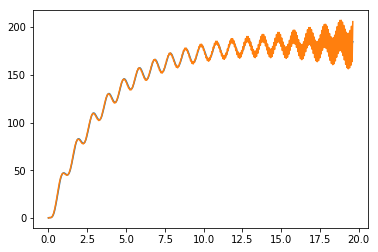

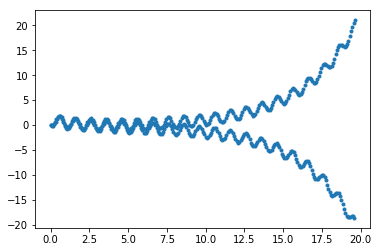

In [9]:
plt.figure()
plt.plot(time_steps/24, mNO_series_euler, label="Euler")
plt.plot(time_steps/24, mNO_series_LF, label="Leap-frog")

plt.figure()
plt.plot(time_steps/24, mNO_series_LF-mNO_series_euler, ".", ls='')